In [47]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd
import re
import sklearn
import numpy as np
from sklearn.neighbors import NearestNeighbors
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5);
sns.set_style('whitegrid')

In [87]:
by_customer = pd.read_csv('./order_by_customer.csv')
customer = pd.read_csv('./customer_basic.csv')
restaurant = pd.read_csv('./restaurant.csv')

In [88]:
by_customer = by_customer.drop('Unnamed: 0',axis=1)
by_customer


,customer_id,VENDOR
0,95B00Z8,189
1,NBHQJXI,195 676 176 265
2,P0RY7TO,92 33 92 33 92 92 92 92 92 134
3,9PJVBKB,676
4,U59I5S8,113 113 583
...,...,...
9995,EVLNX9L,106
9996,4911852,85 197 86
9997,HCEQCH5,843
9998,21XTYX5,681 681


In [112]:
customer

,Unnamed: 0,customer_id,gender,location_number,location_type,latitude_x,longitude_x,city_id,tag_1,tag_2,...,tag_84,tag_85,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91,grand_total,item_count
0,2295661,F8SFBID,0,0,2,0.03290,-78.60000,1.0,1,0,...,0,0,0,0,0,0,0,0,7.100000,2.00000
1,1891238,Y7H5ARO,0,1,2,0.34770,0.60100,1.0,0,0,...,0,0,0,0,0,0,0,0,16.293828,2.44188
2,3472191,0X5LWPM,3,0,2,1.34900,-78.75000,1.0,1,0,...,0,0,0,0,0,0,0,1,16.293828,2.44188
3,3711332,SPWOZIN,0,0,0,-0.27800,-78.56000,1.0,0,1,...,0,0,0,0,0,0,0,0,16.293828,2.44188
4,5256793,5Z468SS,3,0,0,0.54200,0.53370,1.0,1,0,...,0,0,0,0,0,0,0,1,16.293828,2.44188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1654137,6UOCCK3,0,0,2,-0.10315,0.12354,1.0,1,0,...,0,0,0,0,0,0,0,0,16.293828,2.44188
9996,2704492,P584KU2,3,0,2,0.03270,0.53760,1.0,1,0,...,0,0,0,0,0,0,0,1,16.293828,2.44188
9997,5591171,1DBPPPF,3,0,0,0.11237,0.41650,1.0,1,0,...,0,0,0,0,0,0,0,1,16.293828,2.44188
9998,4042570,GDIDS3P,0,1,0,-0.14560,0.10254,1.0,1,0,...,0,0,0,0,0,0,0,1,21.500000,1.00000


In [51]:
for i in restaurant.keys():
    print(i)

Unnamed: 0
vendor_id
vendor_rating2
favorite_by
rated_by
favorite_percentage
rated_percentage
average_price
average_item_sold
latitude
longitude
vendor_category_id
delivery_charge
prepration_time
discount_percentage
status
verified
rank
vendor_rating
one_click_vendor
city_id
tag_1
tag_2
tag_3
tag_4
tag_5
tag_6
tag_7
tag_8
tag_9
tag_10
tag_11
tag_12
tag_13
tag_14
tag_15
tag_16
tag_17
tag_18
tag_19
tag_20
tag_21
tag_22
tag_23
tag_24
tag_25
tag_26
tag_27
tag_28
tag_29
tag_30
tag_31
tag_32
tag_33
tag_34
tag_35
tag_36
tag_37
tag_38
tag_39
tag_40
tag_41
tag_42
tag_43
tag_44
tag_45
tag_46
tag_47
tag_48
tag_49
tag_50
tag_51
tag_52
tag_53
tag_54
tag_55
tag_56
tag_57
tag_58
tag_59
tag_60
tag_61
tag_62
tag_63
tag_64
tag_65
tag_66
tag_67
tag_68
tag_69
tag_70
tag_71
tag_72
tag_73
tag_74
tag_75
tag_76
tag_77
tag_78
tag_79
tag_80
tag_81
tag_82
tag_83
tag_84
tag_85
tag_86
tag_87
tag_88
tag_89
tag_90
tag_91


In [111]:
restaurant

,Unnamed: 0,vendor_id,vendor_rating2,favorite_by,rated_by,favorite_percentage,rated_percentage,average_price,average_item_sold,latitude,...,tag_82,tag_83,tag_84,tag_85,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91
0,0,4,3.926667,14.958667,17,0.378378,0.113333,3.926667,2.597741,-0.588596,...,0,0,0,0,0,0,0,0,0,1
1,1,13,3.781818,18.618182,4,0.345455,0.072727,3.781818,2.138599,-0.471654,...,0,0,0,0,0,0,0,0,0,0
2,2,20,3.991071,21.300893,17,0.318182,0.151786,3.991071,2.603947,-0.407527,...,0,0,0,0,0,0,0,0,0,1
3,3,23,4.275362,20.766667,8,0.362319,0.115942,4.275362,2.298883,-0.585385,...,0,0,0,0,0,0,0,0,0,0
4,4,28,3.700855,13.302564,21,0.147826,0.179487,3.700855,3.054995,0.480602,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,849,4.870588,11.634118,22,0.035294,0.258824,4.870588,1.964706,-1.588060,...,0,0,0,0,0,0,0,0,0,1
96,96,855,4.862069,11.796552,11,0.000000,0.189655,4.862069,2.086207,2.145206,...,0,0,0,0,0,0,0,0,0,1
97,97,856,4.762712,12.676271,16,0.000000,0.271186,4.762712,2.389831,0.251469,...,0,0,0,0,0,0,0,0,0,1
98,98,858,4.827586,10.189655,14,0.034483,0.241379,4.827586,1.793103,0.019817,...,0,0,0,0,0,0,0,0,0,1


In [69]:
customer_array = customer.to_numpy()[:,2:]
restaurant_rare = restaurant.copy()
customer_array

array([[0, 0, 2, ..., 0, 7.1, 2.0],
       [0, 1, 2, ..., 0, 16.29382780031045, 2.4418801313978795],
       [3, 0, 2, ..., 1, 16.29382780031045, 2.4418801313978795],
       ...,
       [3, 0, 0, ..., 1, 16.29382780031045, 2.4418801313978795],
       [0, 1, 0, ..., 1, 21.5, 1.0],
       [0, 0, 2, ..., 0, 16.29382780031045, 2.4418801313978795]],
      dtype=object)

# User Base Recommendation

## Assign weights to each feature

### city_id is supper critical, so we assign large weight. (customer_array[:,5]*=100.) Note that latitude_x and	longitude_x is also important but originally has large variance, so we keep them the same.)
### We want to amplify the customer's preference (customer_array[:,6]*=3.)
### grand_total and	item_count may not be so important, we dilute them (customer_array[:,-2:]/=3.)

### For each query we generate three results, two of them are based on the user's preference. The last one are on food categories that's less frequent

In [54]:
customer_array[:,-2:]/=3.
customer_array[:,5]*=100.
customer_array[:,6:]*=3.

0
[3735 1471 571 3324 5659 888 130 6214 720 1436 294 561 361 0 1210 6143 157
 0 280 0 150 1677 1644 4626 378 157 2374 2146 719 2726 870 1598 1164 627
 570 1005 0 2414 0 0 501 414 1308 438 245 152 284 2065 158 145 371 1886
 114 123 0 458 478 171 0 680 419 378 146 140 0 0 150 0 0 0 143 0 114 0 0 0
 125 0 113 151 0 0 144 0 0 147 0 0 143 147 3322]


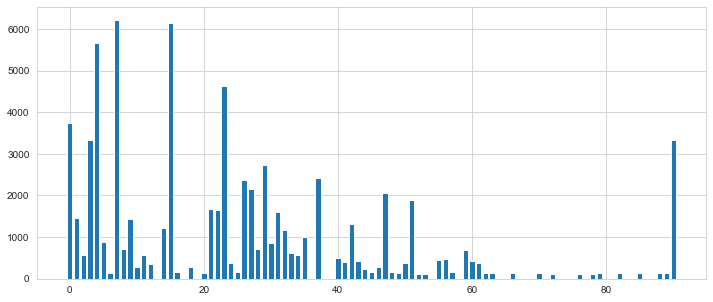

(91,)


In [73]:
customer_array_rare = customer_array.copy()[:,6:-2]
rare_ind = np.abs(np.sum(customer_array_rare,0))>20000
customer_array_rare[:,rare_ind]*=0
print(np.min(customer_array_rare))
distribution = np.sum(customer_array_rare,0)
print(distribution)
plt.bar([i for i in range(len(distribution))],distribution)
plt.show()
print(rare_ind.shape)


for i in range(rare_ind.shape[0]):
    if rare_ind[i]==True:
        index_names = restaurant_rare[(restaurant_rare['tag_'+str(int(i+1))]>0)].index
        restaurant_rare.drop(index_names, inplace = True)
        

In [101]:
by_customer_rare = by_customer.copy()
keep = restaurant_rare['vendor_id'].values.tolist()
print(keep)
for i in range(len(by_customer_rare)):
    s = by_customer_rare.iloc[i]['VENDOR']
    v = s.split(' ')
    v_ = [t for t in v if int(t) in keep]
    s_ = ' '.join(v_)
    by_customer_rare.iloc[i]['VENDOR']= s_
by_customer_rare

[33, 75, 85, 86, 92, 110, 113, 115, 145, 149, 157, 180, 188, 189, 191, 192, 196, 197, 199, 201, 203, 207, 216, 221, 231, 243, 265, 274, 288, 295, 298, 299, 300, 303, 310, 356, 386, 398, 401, 419, 547, 575, 578, 582, 583, 676, 679, 681, 907]


,customer_id,VENDOR
0,95B00Z8,189
1,NBHQJXI,676 265
2,P0RY7TO,92 33 92 33 92 92 92 92 92
3,9PJVBKB,676
4,U59I5S8,113 113 583
...,...,...
9995,EVLNX9L,
9996,4911852,85 197 86
9997,HCEQCH5,
9998,21XTYX5,681 681


In [102]:
index_names = by_customer_rare[(by_customer_rare['VENDOR']=='')].index
by_customer_rare.drop(index_names, inplace = True)
    
by_customer_rare

,customer_id,VENDOR
0,95B00Z8,189
1,NBHQJXI,676 265
2,P0RY7TO,92 33 92 33 92 92 92 92 92
3,9PJVBKB,676
4,U59I5S8,113 113 583
...,...,...
9992,E4NWJGE,207
9994,Z9HE0WS,113 578
9996,4911852,85 197 86
9998,21XTYX5,681 681


In [110]:
remove_customer_ids = customer.iloc[index_names]['customer_id'].values.tolist()
customer_rare = customer.copy()
for name in remove_customer_ids:
    index_names = customer_rare[(customer_rare['customer_id']==name)].index
    customer_rare.drop(index_names, inplace = True)
customer_rare

,Unnamed: 0,customer_id,gender,location_number,location_type,latitude_x,longitude_x,city_id,tag_1,tag_2,...,tag_84,tag_85,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91,grand_total,item_count
0,2295661,F8SFBID,0,0,2,0.0329,-78.60000,1.0,1,0,...,0,0,0,0,0,0,0,0,7.100000,2.00000
1,1891238,Y7H5ARO,0,1,2,0.3477,0.60100,1.0,0,0,...,0,0,0,0,0,0,0,0,16.293828,2.44188
2,3472191,0X5LWPM,3,0,2,1.3490,-78.75000,1.0,1,0,...,0,0,0,0,0,0,0,1,16.293828,2.44188
3,3711332,SPWOZIN,0,0,0,-0.2780,-78.56000,1.0,0,1,...,0,0,0,0,0,0,0,0,16.293828,2.44188
4,5256793,5Z468SS,3,0,0,0.5420,0.53370,1.0,1,0,...,0,0,0,0,0,0,0,1,16.293828,2.44188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9987,3076166,HKIXC9J,0,0,0,-1.6150,-78.40000,1.0,0,0,...,0,0,0,0,0,0,0,0,16.293828,2.44188
9992,2792703,YIG1WJL,0,0,0,-0.0745,-78.56000,1.0,0,0,...,0,0,0,0,0,0,0,0,16.293828,2.44188
9994,4526658,6SLC4VZ,0,2,1,-0.0537,0.13600,1.0,1,0,...,0,0,0,0,0,0,0,0,16.293828,2.44188
9996,2704492,P584KU2,3,0,2,0.0327,0.53760,1.0,1,0,...,0,0,0,0,0,0,0,1,16.293828,2.44188


In [12]:
customer_array

array([[0, 0, 2, ..., 0, 2.3666666666666667, 0.6666666666666666],
       [0, 1, 2, ..., 0, 5.431275933436816, 0.8139600437992932],
       [3, 0, 2, ..., 1, 5.431275933436816, 0.8139600437992932],
       ...,
       [3, 0, 0, ..., 1, 5.431275933436816, 0.8139600437992932],
       [0, 1, 0, ..., 1, 7.166666666666667, 0.3333333333333333],
       [0, 0, 2, ..., 0, 5.431275933436816, 0.8139600437992932]],
      dtype=object)

In [13]:
customer_array[0]

array([0, 0, 2, 0.0329, -78.6, 100.0, 3.0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.3666666666666667,
       0.6666666666666666], dtype=object)

In [113]:
customer_rare_array = customer_rare.to_numpy()[:,2:]
customer_rare_array[:,-2:]/=3.
customer_rare_array[:,5]*=100.
customer_rare_array[:,6:]*=3.

## fit KNN model

In [114]:
'''
samples = [[0, 0, 2], [1, 0, 0], [0, 0, 1]]
neigh = NearestNeighbors(2, 0.4)
neigh.fit(samples) 
neigh.kneighbors([[0, 0, 1.3]], 2, return_distance=False)
'''
neigh = NearestNeighbors(2, 0.4)
neigh.fit(customer_array) 

neigh_rare = NearestNeighbors(2, 0.4)
neigh_rare.fit(customer_rare_array) 

C:\Users\anban\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=2, radius=0.4 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\anban\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=2, radius=0.4 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


NearestNeighbors(n_neighbors=2, radius=0.4)

## Predict

In [115]:
neigh.kneighbors([[0, 0, 2, 0.0329, -78.6, 10000.0, 9.0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7888888888888889,
       0.2222222222222222]], 2, return_distance=True)

(array([[9999.00434879, 9999.00449919]]), array([[ 686, 4073]], dtype=int64))

In [116]:
neigh.kneighbors([[0, 0, 2, 0.0329, -78.6, 10000.0, 9.0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.7888888888888889,
       0.2222222222222222]], 2, return_distance=True)

(array([[9999.00449881, 9999.00464921]]), array([[ 686, 4073]], dtype=int64))

In [117]:
neigh.kneighbors([[0, 0, 2, 0.0329, -78.6, 10000.0, 9.0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0,
       0.2222222222222222]], 2, return_distance=True)

(array([[9999.00593083, 9999.00596171]]), array([[ 686, 1195]], dtype=int64))

## Give Recommendation

In [136]:
q = [[0, 0, 2, 0.0329, -78.6, 10000.0, 9.0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0,
       0.2222222222222222]]

def query(user_vecs, neigh, pool, k_value=3, return_num=1):
    dist, knn = neigh.kneighbors(user_vecs, k_value, return_distance=True)
    recommendation = []
    recommendation_weight = []
    #print(dist,knn)
    for k,i in enumerate(list(knn)):
        
        #print(pool.iloc[i])
        recommended_restaurant = pool.iloc[i]['VENDOR'].values
        recommended_restaurant = [s.split(' ') for s in recommended_restaurant]
        confidence = {}
        for j in range(len(recommended_restaurant)):
            for restaurant in recommended_restaurant[j]:
                if restaurant not in confidence:
                    confidence[restaurant]=0.
                confidence[restaurant]+=1./dist[0][j]
        p = np.asarray(list(confidence.values()))
        p/=np.sum(p)
        keys = list(confidence.keys())
        recommendation.append(np.random.choice(len(confidence.keys()), return_num, p=p,replace=False))
        ret = [keys[recommendation[-1][n]]for n in range(return_num)]
        #print("generate recommendation for %d'th input..."%k)
        #print("--Recommendation is restaurant: "+str(ret))
        return ret
        

def generate_recommendation(user_vecs):
    l1 = query(user_vecs, neigh, by_customer, k_value=3, return_num=2)
    l2 = query(user_vecs, neigh_rare, by_customer_rare, k_value=3, return_num=1)
    l1.extend(l2)
    return l1

generate_recommendation(q)

['846', '386', '386']

# Generate Recommendation for Group 

In [138]:
def generate_recommendation_for_group(user_vecs):
    hybrid_preference = np.sum(np.asarray(user_vecs)[:,6:-2],0).tolist()
    vote = []
    vote_rare = []
    count_freq = {}
    for user_vec in user_vecs:
        user_vec[6:-2]=hybrid_preference
        recommendation = generate_recommendation([user_vec])
        vote.extend(recommendation[:2])
        vote_rare.extend(recommendation[2:])
    for k in vote:
        if k not in count_freq:
            count_freq[k]=0
        count_freq[k]+=1
    count_freq = sorted(count_freq.items(),key=lambda x:x[1], reverse=True)
    ret =[i[0] for i in count_freq[:2]]
    count_freq = {}
    for k in vote_rare:
        if k not in count_freq:
            count_freq[k]=0
        count_freq[k]+=1
    count_freq = sorted(count_freq.items(),key=lambda x:x[1], reverse=True)
    ret.append(count_freq[0][0])
    #print("generate recommendation for group...")
    #print("--Recommendation is restaurant: "+str(ret))
    return ret

In [139]:
generate_recommendation_for_group(customer_array[:10].tolist())

['846', '583', '398']

# Item Base Recommendation

## Assign weights to each feature

### city_id is supper critical, so we assign large weight. (customer_array[:,5]*=100.) Note that latitude_x and	longitude_x is also important but originally has large variance, so we keep them the same.)
### We want to amplify the customer's preference (customer_array[:,6]*=3.)
### grand_total and	item_count may not be so important, we dilute them (customer_array[:,-2:]/=3.)